## Transverse field Ising model to demo primitives

In [5]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate

In [4]:
import numpy as np

In [10]:
SYGate = UnitaryGate(YGate().power(1/2),label = r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(),label = r"$\sqrt{Y}^\dag$")


def generate_1D_tfin_im(num_qubits,num_trotter_steps, rx_angle, num_cl_bits = 0, trotter_barriers = False, layer_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    for trotter_step in range(num_trotter_steps):
        add_1D_tfin_trotter_layer(qc,rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_1D_tfin_trotter_layer(qc,rx_angle,layer_barriers = False):
    #Adding Rzz in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.sdg([i,i+1])
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()
    #Adding Rzz in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.sdg([i,i+1])
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()

    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
        
    

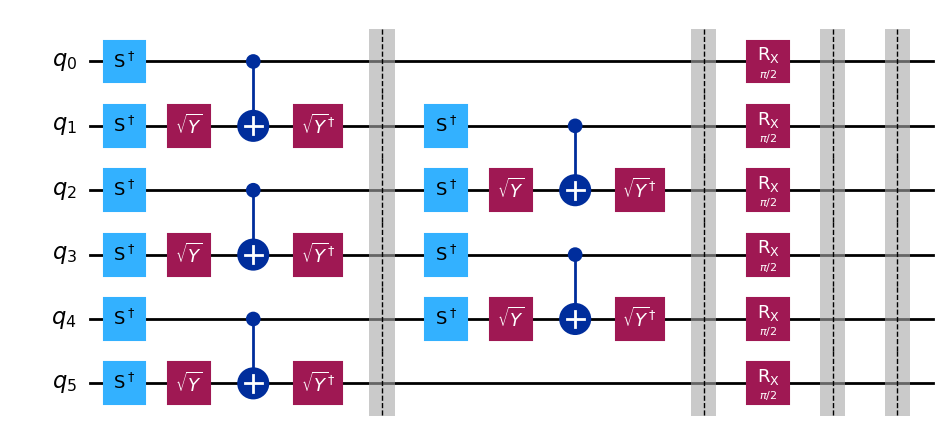

In [11]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5*np.pi

qc = generate_1D_tfin_im(num_qubits,num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
qc.draw(output = "mpl")

In [12]:
def add_miirored_1D_tfin_im(qc, num_qubits,num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):
    for trotter_step in range(num_trotter_steps):
        add_mirrored_1D_tfin_trotter_layer(qc,rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

def add_mirrored_1D_tfin_trotter_layer(qc,rx_angle,layer_barriers = False):
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    #Adding Rzz in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
        qc.s([i,i+1])
    if layer_barriers:
        qc.barrier()
    #Adding Rzz in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
        qc.s([i,i+1])
    if layer_barriers:
        qc.barrier()

add_miirored_1D_tfin_im(qc, num_qubits,num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
    

  

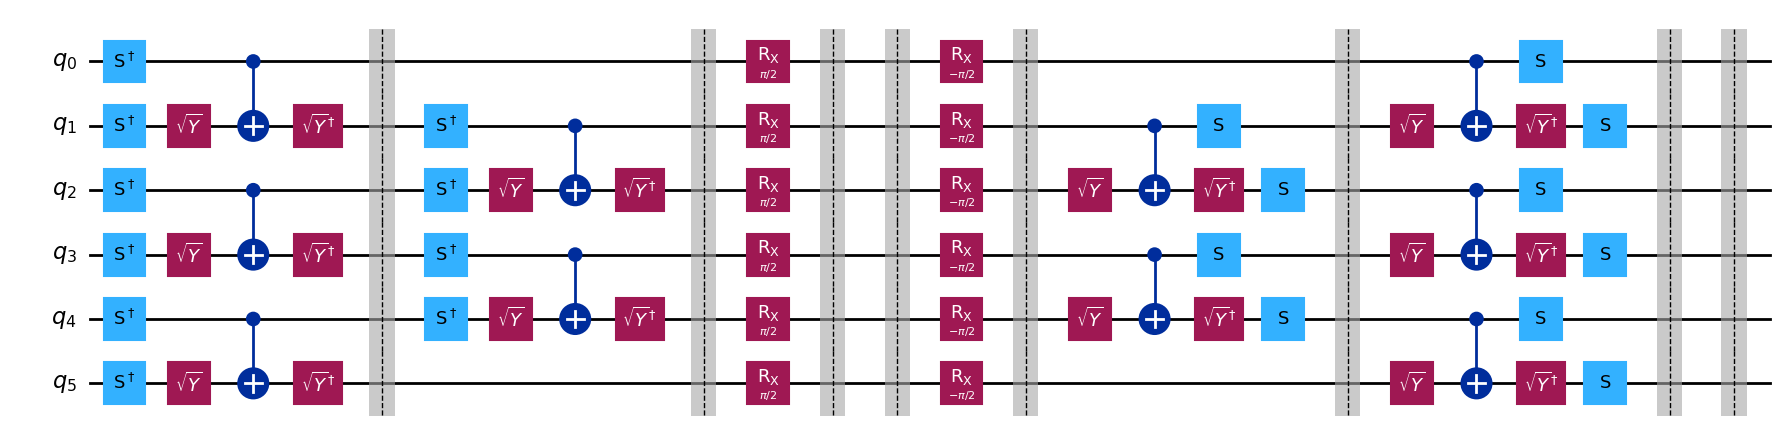

In [13]:
qc.draw(output = "mpl",fold = -1)

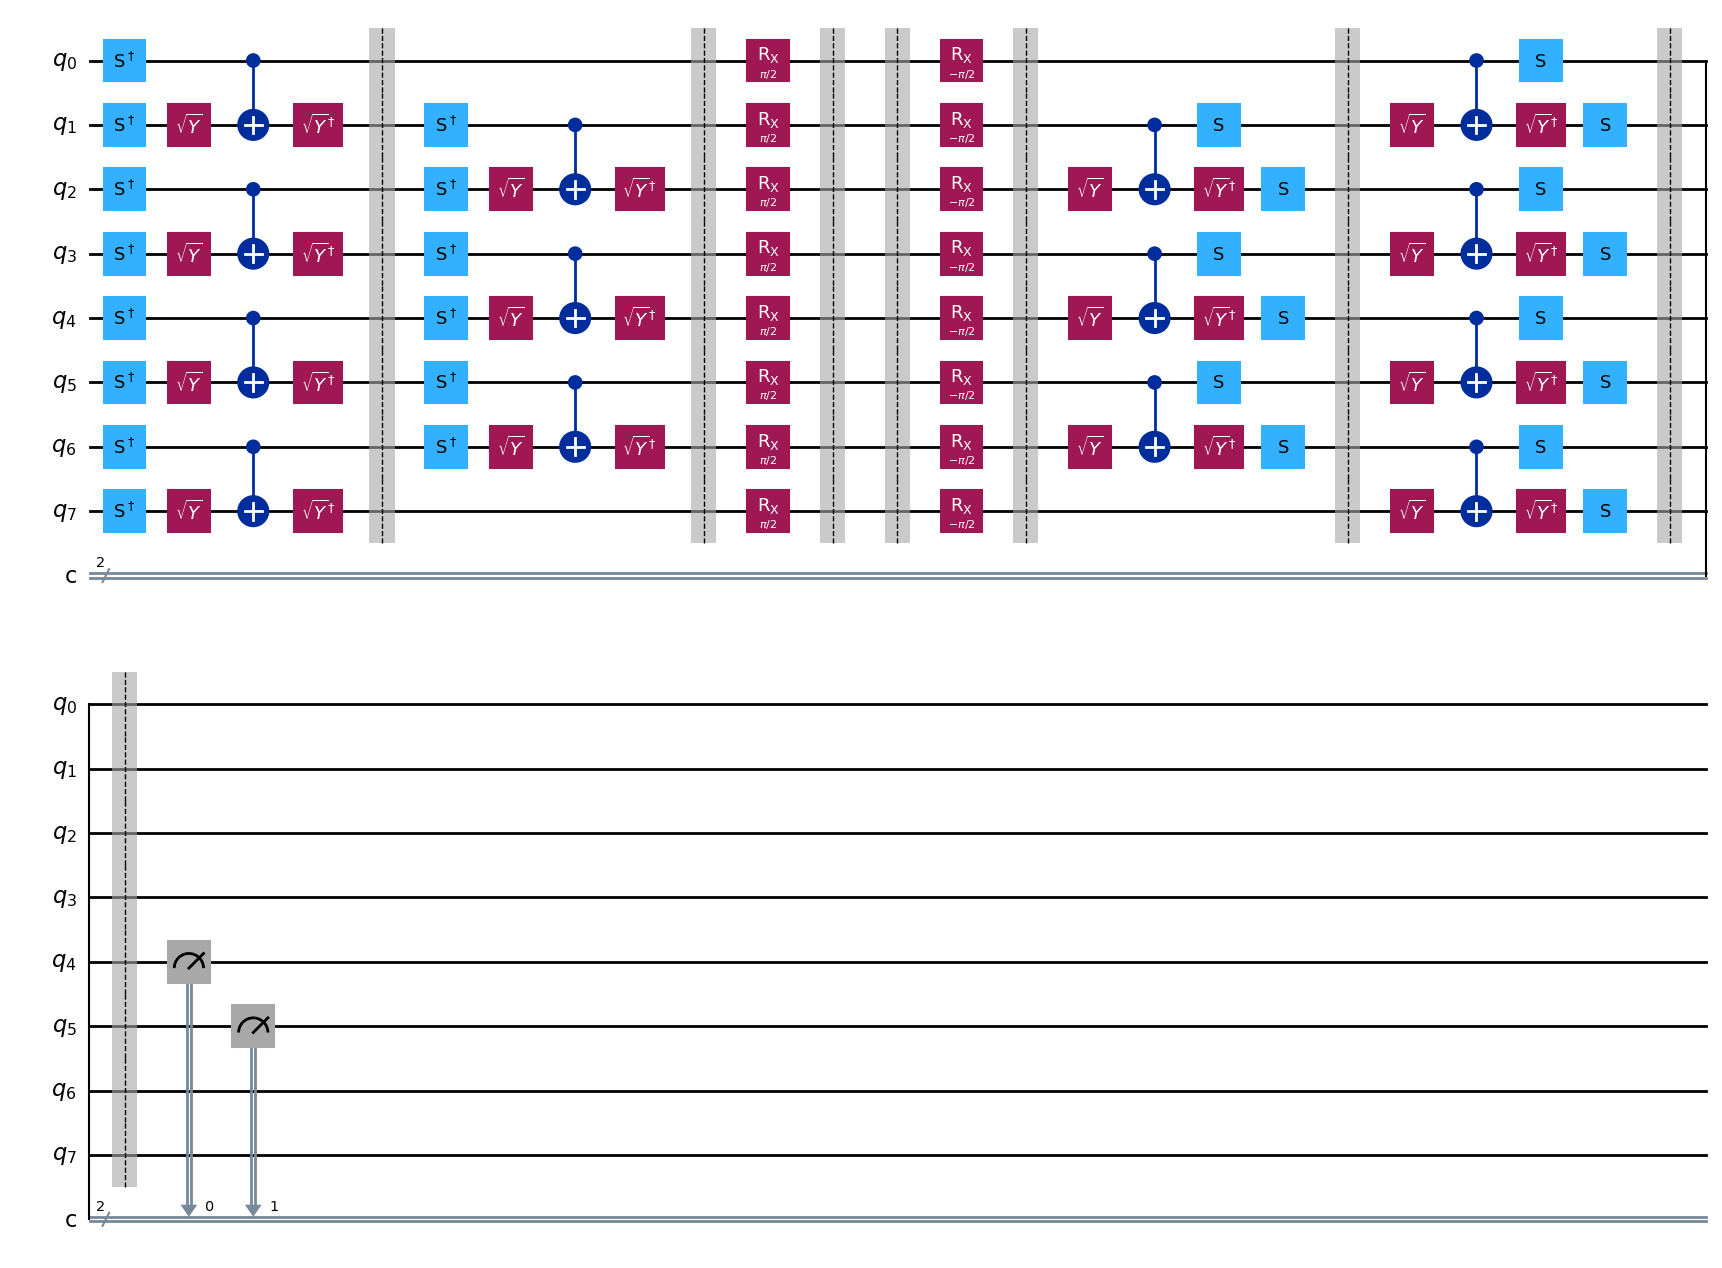

In [14]:
max_trotter_steps = 10
num_qubits = 8
measured_bits =[4,5]

qc_list = []
for trotter_steps in range(max_trotter_steps):
    qc = generate_1D_tfin_im(num_qubits,trotter_steps, rx_angle, num_cl_bits = len(measured_bits), trotter_barriers = True, layer_barriers = True)
    add_miirored_1D_tfin_im(qc, num_qubits,trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
    qc.measure(measured_bits,list(range(len(measured_bits))))
    qc_list.append(qc)

qc_list[1].draw(output = "mpl")
    
    
    

In [15]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
print('Done getting backend')


qc_transpiled_list = transpile(qc_list,backend = backend, optimization_level = 1)

AccountNotFoundError: 'Unable to find account.'

In [10]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = 'XY4'

job = sampler.run(qc_transpiled_list)
print(job.job_id())

cs14q3c75q40008tmb5g


In [11]:
job_id = 'cs09sbdkfpw00080b96g'
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0'*len(measured_bits)]/data.c.num_shots)
    except:
        survival_probability_list.append(0)
    

In [19]:
import matplotlib.pyplot as plt

plt.plot(list(range(0,4*max_trotter_steps,4)),survival_probability_list,'--o')
plt.xlabel('2Q gate depth')
plt.ylabel('Survival probability of the all-0 bitstring')
plt.xticks(np.arange(0,44,4))
plt.show()

NameError: name 'survival_probability_list' is not defined

In [16]:
from qiskit.circuit import Parameter
rx_angle = Parameter('rx_angle')
num_trotter_steps = 2
qc = generate_1D_tfin_im(num_qubits,num_trotter_steps, rx_angle)

from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits //2
observable = SparsePauliOp('I'*middle_index + 'Z' + 'I'*(middle_index-1))

In [14]:
qc_transpiled = transpile(qc, backend=backend,optimization_level = 1)
observable =observable.apply_layout(qc_transpiled.layout)

In [15]:
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2
num_rx_angle = 12

rx_angle_list = np.linspace(min_rx_angle,max_rx_angle,num_rx_angle)
options = EstimatorOptions()

options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = 'XY4'

estimator = EstimatorV2(backend = backend,options = options)
job = estimator.run([(qc_transpiled, observable, rx_angle_list)])

print(job.job_id())

cs14q4m75q40008tmb60


## Coding the fsim gates, we create a function to add such gates

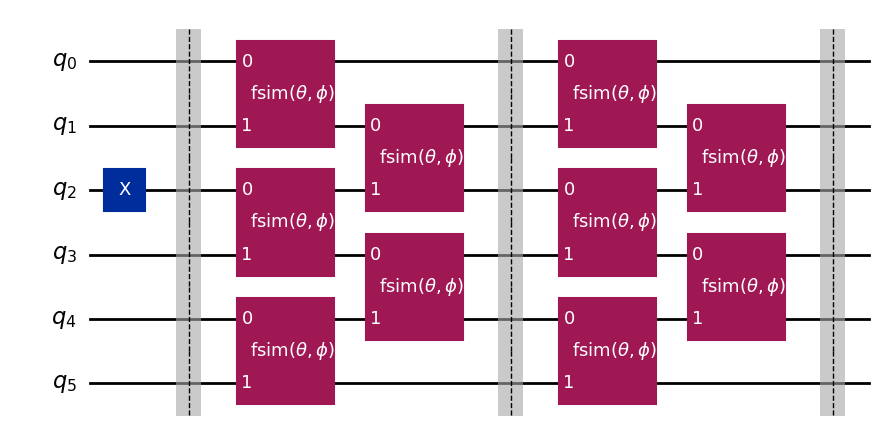

In [7]:
from qiskit.quantum_info import Operator
import math as m
import cmath as cm

def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def circuit(num_qubits, pos1, trotter_steps,angles = [0,0,0], num_cl_bits = 0, trotter_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    qc.x(pos1-1)
    qc.barrier()
    for trotter_step in range(trotter_steps):
        add_fsim(qc,angles)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_fsim(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')


num_qubits = 6
trotter_steps = 2
pos1 = 3
angles = [np.pi/4,0,0]
qc = circuit(num_qubits,pos1,trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl')
    

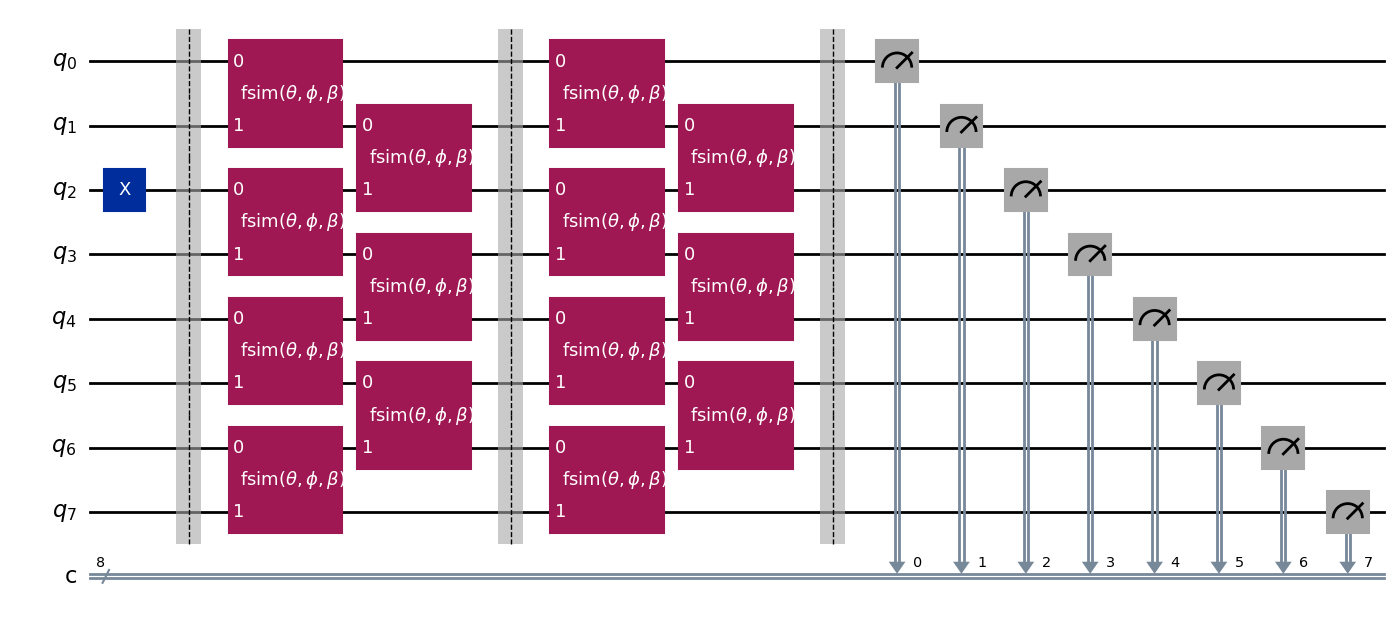

In [17]:
max_trotter_steps = 10
num_qubits = 8
measured_bits =[0,1,2,3,4,5,6,7]

qc_list = []
for trotter_steps in range(max_trotter_steps):
    qc = circuit(num_qubits,pos1, trotter_steps, angles, num_cl_bits = len(measured_bits), trotter_barriers = True)
    qc.measure(measured_bits,list(range(len(measured_bits))))
    qc_list.append(qc)

qc_list[2].draw(output = "mpl")

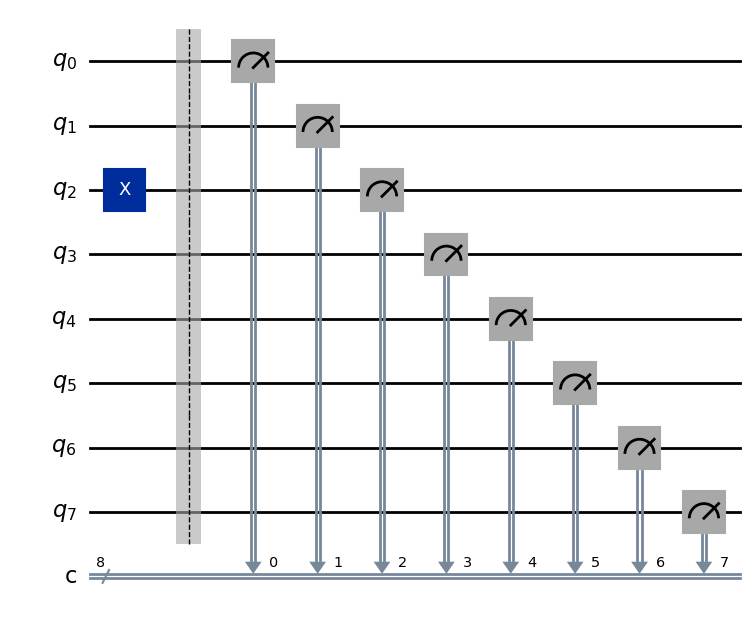

In [18]:
qc_list[0].draw(output = "mpl")

In [19]:
qc_transpiled_list = transpile(qc_list,backend = backend, optimization_level = 1)

In [21]:
#job = sampler.run(qc_transpiled_list)
#print(job.job_id())

cs14qadyhpyg008agn00


In [22]:
def required_bitsrings(num_qubits):
    bitstring_list = ['0'*i +'1' + '0'*(num_qubits-i-1) for i in range(num_qubits)]
    return bitstring_list

string_list = required_bitsrings(num_qubits)
for i in range(len(string_list)):
    string_list[i] = string_list[i][::-1]
print(string_list)


['00000001', '00000010', '00000100', '00001000', '00010000', '00100000', '01000000', '10000000']


[0.00146484375, 0.0009765625, 0.8212890625, 0.001220703125, 0, 0, 0.000732421875, 0.000244140625]
[0.004150390625, 0.00537109375, 0.002685546875, 0.022705078125, 0.6572265625, 0.00244140625, 0.000732421875, 0.00048828125]
[0.007080078125, 0.03271484375, 0.004150390625, 0.0078125, 0.003173828125, 0.001953125, 0.514892578125, 0.003662109375]
[0.02734375, 0.005615234375, 0.009765625, 0.005615234375, 0.005615234375, 0.004638671875, 0.00537109375, 0.40869140625]
[0.00341796875, 0.003662109375, 0.025390625, 0.005859375, 0.01123046875, 0.31103515625, 0.0107421875, 0.006591796875]
[0.0048828125, 0.004150390625, 0.0048828125, 0.28466796875, 0.01123046875, 0.00537109375, 0.0107421875, 0.005859375]
[0.002685546875, 0.23193359375, 0.005615234375, 0.00390625, 0.00732421875, 0.005859375, 0.009521484375, 0.00927734375]
[0.21728515625, 0.0078125, 0.010009765625, 0.003662109375, 0.007080078125, 0.0078125, 0.00537109375, 0.0087890625]
[0.010009765625, 0.00830078125, 0.147216796875, 0.009521484375, 0.011

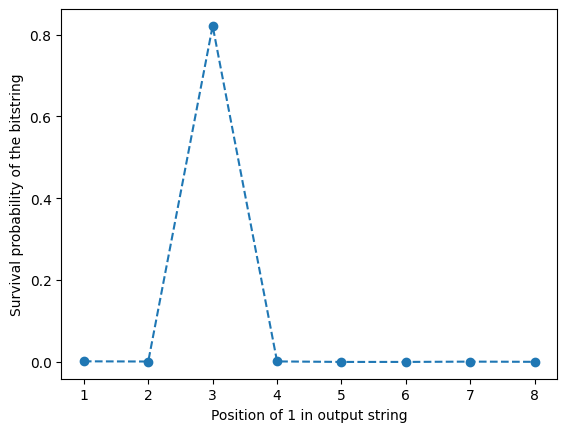

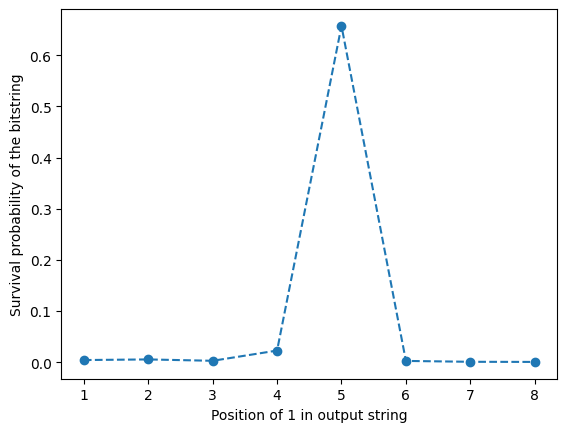

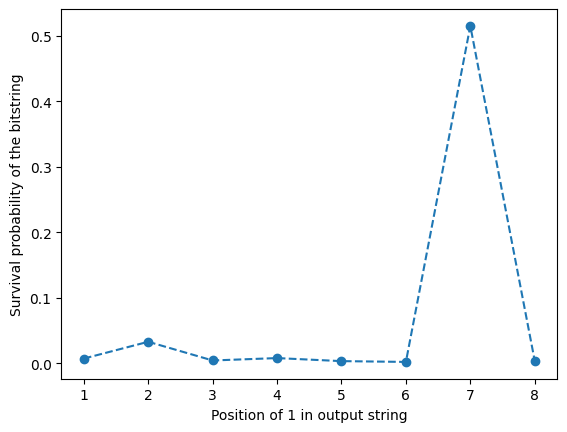

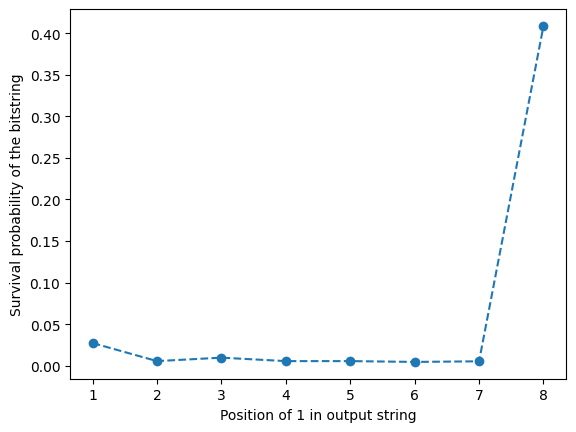

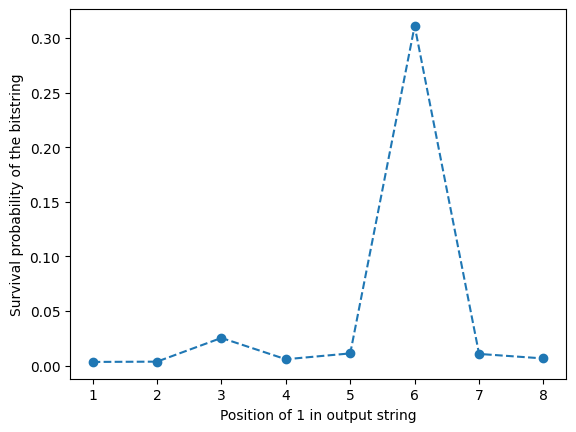

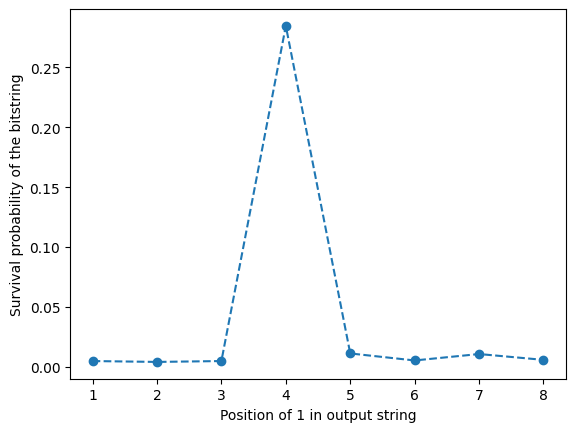

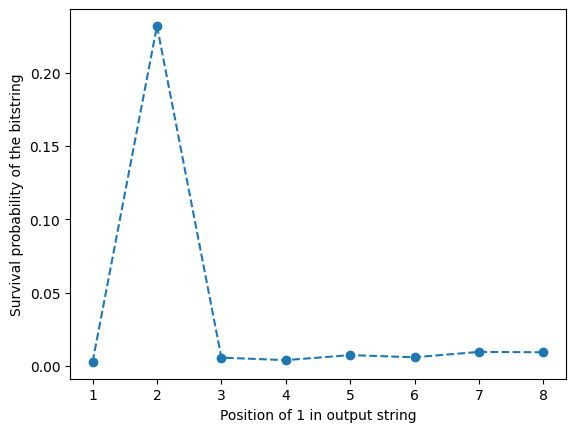

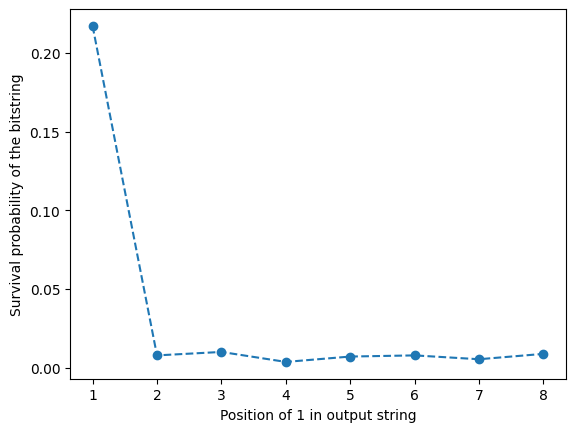

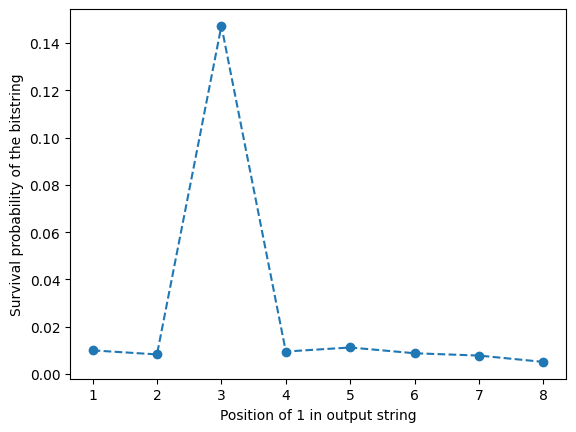

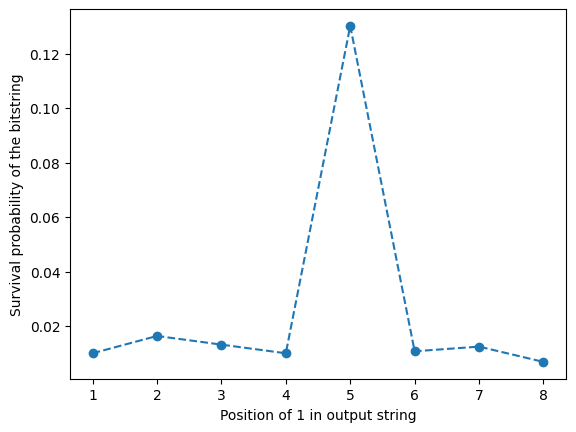

In [23]:
job_id = 'cs0g0a1965y00084z3kg'
job = service.job(job_id)

string_distribution_list = []
for trotter_step in range(max_trotter_steps):
    data = job.result()[trotter_step].data
    list1 = []
    for i in string_list:
        try:
            list1.append(data.c.get_counts()[i]/data.c.num_shots)
        except:
            list1.append(0)
    print(list1)
    string_distribution_list.append(list1)

            
for trotter_step in range(max_trotter_steps):
    plt.plot(list(range(1,num_qubits+1)),string_distribution_list[trotter_step],'--o')
    plt.xlabel('Position of 1 in output string')
    plt.ylabel('Survival probability of the bitstring')
    plt.xticks(np.arange(1,9))
    plt.show()

[{4: 1.0}, {16: 0.25, 2: 0.25, 4: 0.25, 8: 0.25}, {1: 0.125, 16: 0.5625, 2: 0.0625, 32: 0.0625, 4: 0.0625, 64: 0.0625, 8: 0.0625}, {1: 0.182138347648319, 16: 0.0625, 2: 0.091069173824159, 32: 0.140625, 4: 0.039292478527522, 64: 0.390625, 8: 0.0625, 128: 0.03125}, {1: 0.0078125, 16: 0.082146239263761, 2: 0.114506673824159, 32: 0.0078125, 4: 0.152228760736239, 64: 0.287952065439602, 8: 0.026118326175841, 128: 0.321422934560398}, {1: 0.03125, 16: 0.005361652351682, 2: 0.00390625, 32: 0.007047033230885, 4: 0.239391684560398, 64: 0.01305916308792, 8: 0.091069173824159, 128: 0.608915042944956}, {1: 0.00652958154396, 16: 0.160711467280199, 2: 0.04553458691208, 32: 0.135953283230886, 4: 0.00067020654396, 64: 0.276558554192279, 8: 0.152228760736239, 128: 0.221813559560398}, {1: 0.0087890625, 16: 0.039292478527522, 2: 0.003712417177896, 32: 0.780100530483374, 4: 0.126112900690224, 64: 0.012910917369552, 8: 0.027573728527522, 128: 0.00150796472391}, {1: 0.000538589052896, 16: 0.191003999137329, 2

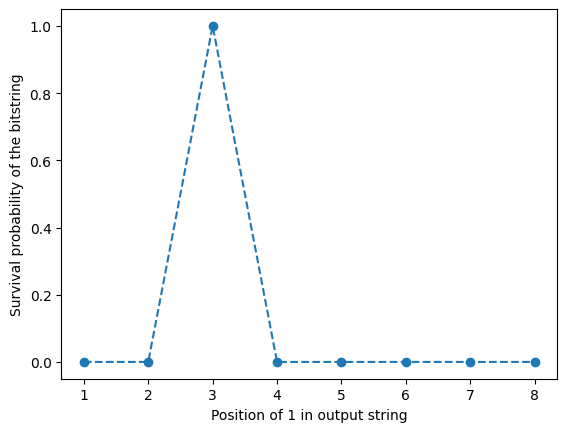

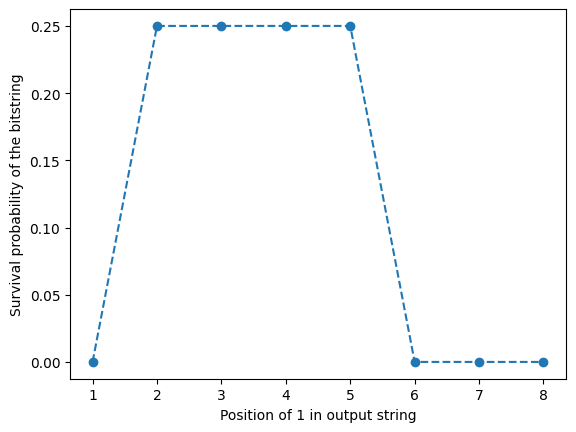

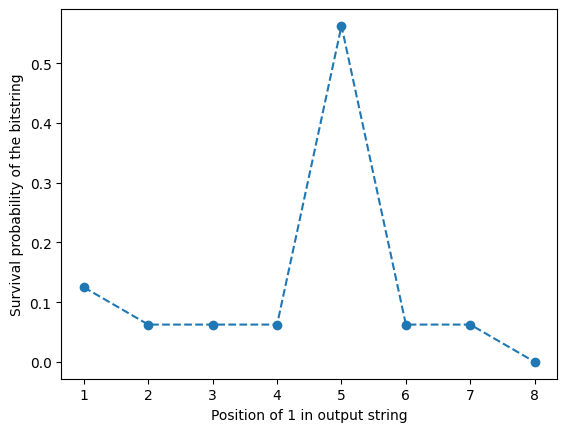

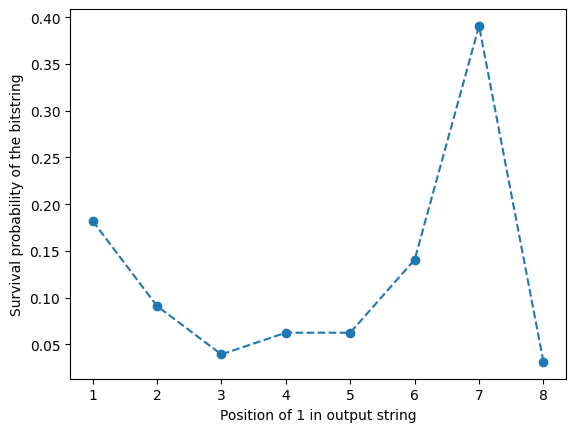

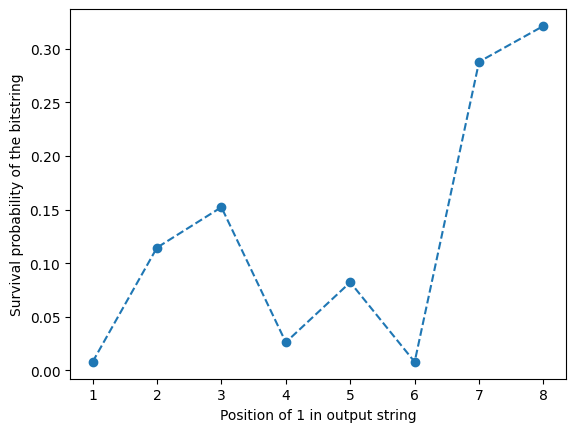

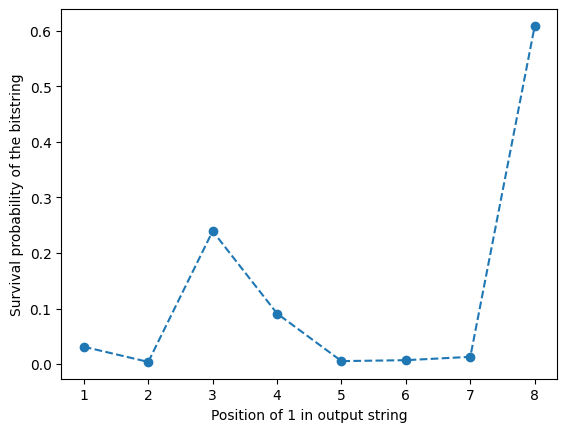

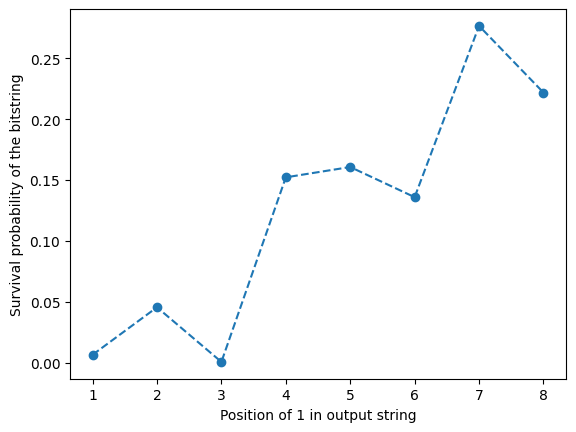

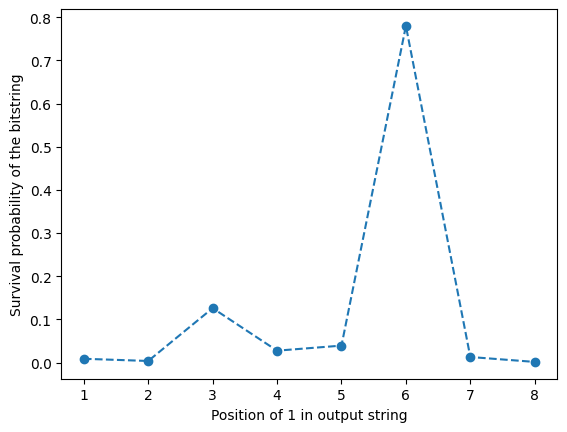

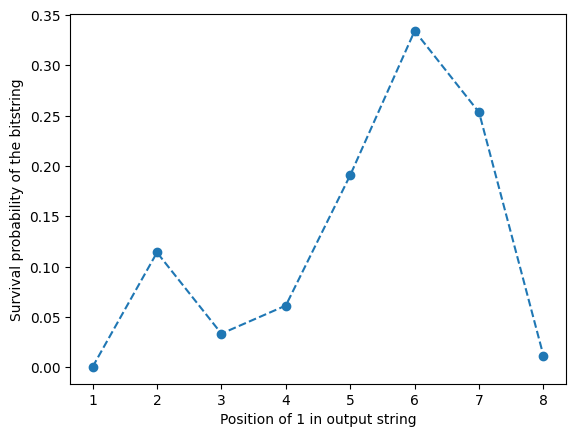

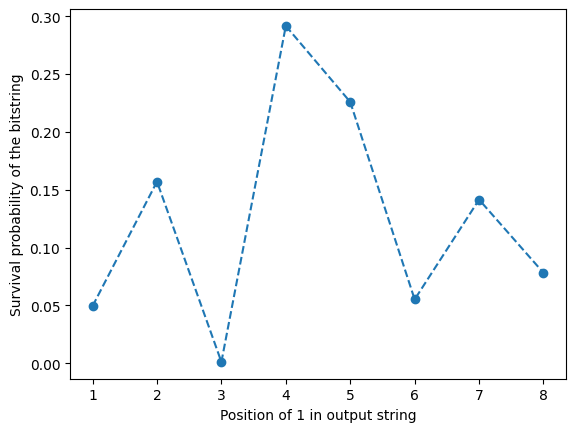

In [24]:
from qiskit_aer.primitives import Sampler

sampler = Sampler()
job = sampler.run(qc_list,shots = None)
exact_quasis = job.result().quasi_dists
print(exact_quasis)

sim_distribution_list = []
for trotter_step in range(max_trotter_steps):
    data = job.result().quasi_dists[trotter_step]
    list1 = []
    for i in string_list:
        num = int(i,2)
        try:
            list1.append(data[num])
        except:
            list1.append(0)
        
    print(list1)
    sim_distribution_list.append(list1)


for trotter_step in range(max_trotter_steps):
    plt.plot(list(range(1,num_qubits+1)),sim_distribution_list[trotter_step],'--o')
    plt.xlabel('Position of 1 in output string')
    plt.ylabel('Survival probability of the bitstring')
    plt.xticks(np.arange(1,9))
    plt.show()

## Calculating the band structure for a ring arrangement

In [2]:
from qiskit_aer.primitives import Estimator

def circuit_ring(num_qubits, pos1, trotter_steps,angles = [0,0,0], num_cl_bits = 0, trotter_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    qc.h(pos1-1)
    qc.barrier()
    for trotter_step in range(trotter_steps):
        add_fsim_ring(qc,angles)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_fsim_ring(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi,\beta)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi,\beta)$')

    #Adding fsim between first and last qubit
    qc.unitary(fsim1,[qc.num_qubits-1,0],label = r'fsim$(\theta,\phi,\beta)$')

def estimate(qc_list,num_qubits):
    x_observables = [SparsePauliOp('I'*i + 'X' + 'I'*(num_qubits-1-i)) for i in range(num_qubits)]
    y_observables = [SparsePauliOp('I'*i + 'Y' + 'I'*(num_qubits-1-i)) for i in range(num_qubits)]
    #plus_obervables = x_observables + 1j*y_observables
    #plus_obervables= [observable.apply_layout(qc_transpiled_list.layout) for observable in plus_observables]

    estimator =  Estimator()
    job_x = estimator.run(qc_list,x_observables,shots = None)
    job_y = estimator.run(qc_list,y_observables,shots = None)
    expectation_list_x = list(job_x.result().values)
    expectation_list_y = list(job_y.result().values)

    expectation_list = [expectation_list_x[i] + 1j*expectation_list_y[i] for i in range(len(expectation_list_x))]

    return expectation_list

    
    


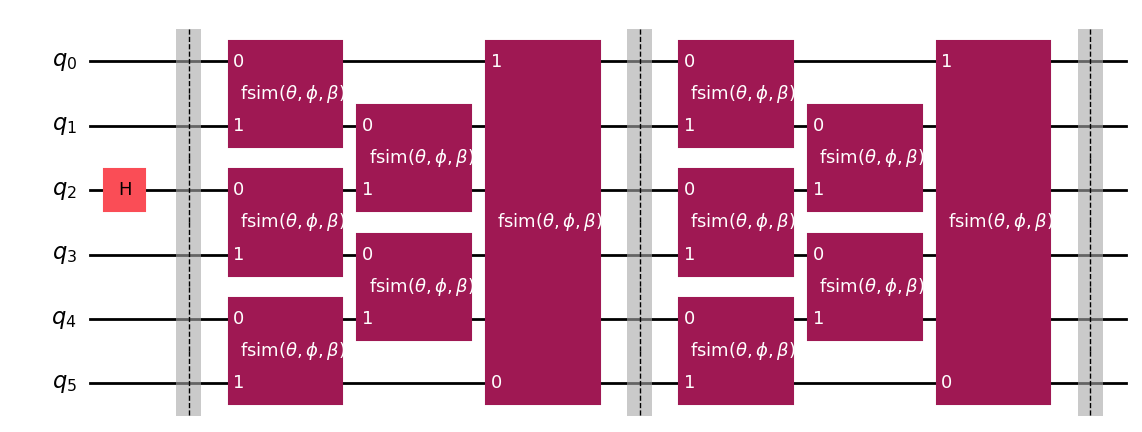

In [22]:
num_qubits = 6
num_trotter_steps = 15
angles = [np.pi/6,np.pi/2,0]

pos1 = 3
trotter_steps = 2

qc = circuit_ring(num_qubits, pos1, trotter_steps,angles = angles, num_cl_bits = 0, trotter_barriers = True)
qc.draw(output='mpl')




In [23]:
evs_array = []
for trotter_step in range(num_trotter_steps):
    qc_list = []
    for pos in range(num_qubits):
        qc = circuit_ring(num_qubits, pos1, trotter_step,angles = angles)
        qc_list.append(qc)
    evs_array.append(estimate(qc_list,num_qubits))

evs_array_real = []
evs_array_imag = []
for i in evs_array:
    real_arr = [i[k].real for k in range(len(i))]
    imag_arr = [i[k].imag for k in range(len(i))]
    evs_array_real.append(real_arr)
    evs_array_imag.append(imag_arr)

print(evs_array_imag)
        
    


/tmp/ipykernel_3936/2870534160.py:7: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  evs_array.append(estimate(qc_list,num_qubits))


[[0.017578125, 0.015625, -0.07421875, -0.0078125, -0.064453125, -0.013671875], [-0.033203125, 0.0078125, 0.41796875, 0.03125, 0.4296875, 0.01953125], [-0.19921875, 0.00390625, 0.5390625, -0.05859375, 0.580078125, 0.029296875], [-0.578125, -0.037109375, 0.25390625, 0.0390625, 0.28515625, 0.015625], [-0.82421875, 0.0234375, -0.009765625, -0.0390625, -0.056640625, -0.0390625], [-0.6484375, 0.02734375, -0.1640625, -0.05859375, -0.072265625, 0.01171875], [-0.076171875, 0.015625, -0.009765625, -0.025390625, 0.03125, -0.0078125], [0.546875, -0.009765625, 0.169921875, 0.044921875, 0.1875, -0.0390625], [0.73828125, 0.080078125, 0.052734375, -0.015625, 0.08984375, -0.03125], [0.6171875, -0.00390625, -0.234375, 0.072265625, -0.28125, -0.017578125], [0.271484375, -0.033203125, -0.5703125, 0.015625, -0.53125, -0.046875], [0.12109375, -0.02734375, -0.5, 0.01953125, -0.47265625, 0.0078125], [0.107421875, -0.0078125, -0.083984375, 0.03515625, -0.138671875, 0.005859375], [0.14453125, -0.029296875, 0.27

In [51]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(channel = "ibm_quantum", #ibm_cloud
                               token = '60cc76a21936e2369c78f5c20e3aeafa53ce9611689830e893ca4ae55a556e12257888b95e65997248c6c64f75e79af7d183ce999c2d0e9077625aa5c03817a4')
#service.save_account(channel = "ibm_quantum", #ibm_cloud
                              #token = '60cc76a21936e2369c78f5c20e3aeafa53ce9611689830e893ca4ae55a556e12257888b95e65997248c6c64f75e79af7d183ce999c2d0e9077625aa5c03817a4')
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=num_qubits)

print(backend.name)

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)




    
    

ibm_brisbane


In [53]:
def estimate2(qc_list,num_qubits):
    x_observables = [SparsePauliOp('I'*i + 'X' + 'I'*(num_qubits-1-i)) for i in range(num_qubits)]
    y_observables = [SparsePauliOp('I'*i + 'Y' + 'I'*(num_qubits-1-i)) for i in range(num_qubits)]

    pubs_x = []
    pubs_y = []

    for qc, obs in zip(qc_list, x_observables):
        isa_circuit = pm.run(qc)
        isa_obs = obs.apply_layout(isa_circuit.layout)
        pubs_x.append((isa_circuit, isa_obs))

    for qc, obs in zip(qc_list, y_observables):
        isa_circuit = pm.run(qc)
        isa_obs = obs.apply_layout(isa_circuit.layout)
        pubs_y.append((isa_circuit, isa_obs))

    estimator = Estimator2(backend)
    job_x = estimator.run(pubs_x)
    job_y = estimator.run(pubs_y)

    job_x_results = job_x.result()
    job_y_results = job_y.result()

    expectation_list = [job_x_results[i].data.evs + 1j*job_y_results[i].data.evs for i in range(num_qubits)]

    return expectation_list

evs_array2 = []
for trotter_step in range(num_trotter_steps):
    qc_list = []
    for pos in range(num_qubits):
        qc = circuit_ring(num_qubits, pos, trotter_step,angles = angles)
        qc_list.append(qc)
    evs_array2.append(estimate2(qc_list,num_qubits))

evs_array_real2 = []
evs_array_imag2 = []
for i in evs_array2:
    real_arr2 = [i[k].real for k in range(len(i))]
    imag_arr2 = [i[k].imag for k in range(len(i))]
    evs_array_real2.append(real_arr2)
    evs_array_imag2.append(imag_arr2)

print(evs_array_imag2)

KeyboardInterrupt: 

## Code to do Fourier transform

In [54]:
#Let us just see what happends if we use scipy's 2D FFT firstly

import scipy.fft as fft

fft_2d = fft.fft2(evs_array)
print(fft_2d)

[[-0.765625  +0.19335938j  0.19833981-3.07594571j  4.20179787-0.06759315j
   0.171875  -0.17382812j  4.13413963-0.1081881j  -0.06552731+2.81032071j]
 [ 4.38822778-2.54794106j  0.45384669+0.92206073j  1.24550408-2.96293445j
   0.24114179+0.08247036j  1.097841  -3.11137558j -0.43207068-0.93822146j]
 [ 1.16947831-0.10912743j -0.27042685+0.47691606j  1.43386751-0.47277042j
   0.08413035-0.29978826j  1.72953827-0.36663901j  0.04617542-0.32958411j]
 [ 1.18963082+0.19581096j -0.19583877+0.51154804j  1.78033828+0.69386238j
  -0.11887692+0.20388333j  1.86808468+0.47397663j  0.14526949-0.49746526j]
 [ 4.15500685+2.63899191j -0.52500712+0.82346129j  1.07561546+3.00612525j
   0.01235478-0.0080498j   1.29655446+2.63233332j  0.25461432-0.94723093j]]


In [57]:
fft_2d_abs = np.abs(fft_2d)**2
print(fft_2d_abs)

[[6.23569489e-01 9.50078068e+00 1.76596742e+01 5.97572327e-02
  1.71028152e+01 7.90219631e+00]
 [2.57485467e+01 1.05617282e+00 1.03302610e+01 6.49507251e-02
  1.08859129e+01 1.06694457e+00]
 [1.37958831e+00 3.00579613e-01 2.27948790e+00 9.69509163e-02
  3.12572679e+00 1.10757852e-01]
 [1.45356341e+00 3.00034226e-01 3.65104940e+00 5.57001327e-02
  3.71439423e+00 2.68574914e-01]
 [2.42283602e+01 9.53720977e-01 1.01937376e+01 2.17439817e-04
  8.61023221e+00 9.62074891e-01]]


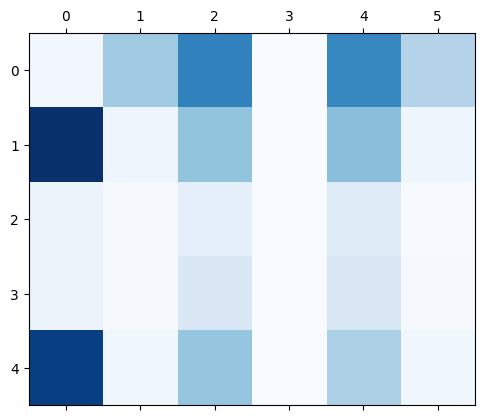

In [58]:
plt.matshow(fft_2d_abs, cmap=plt.cm.Blues)

In [27]:
#Making our own discrete fourier tansform function

def dft_2d(evs_array,n_k = 10, n_w = 10):
    t = evs_array.shape[0]
    j = evs_array.shape[1]

    dft_arr = np.zeros((n_w,n_k),dtype=complex)
    w_arr = np.linspace(-np.pi,np.pi,n_w)  #can be updated for more points on the dft graph
    k_arr = np.linspace(-np.pi,np.pi,n_k)
    for i in range(n_w):
        for l in range(n_k):
            dft_arr[i,l] = exp_sum(evs_array,w_arr[i],k_arr[l])
            #print(dft_arr[i,l])
    dft_arr = 2*m.sqrt(num_qubits)*dft_arr/(n_k*n_w)

    return dft_arr

def exp_sum(evs_array,w,k):
    t = evs_array.shape[0]
    j = evs_array.shape[1]
    sum = 0 + 0j
    for n in range(t):
        for m in range(j):
            sum += evs_array[n,m]*cm.exp(-1j*(w*n - k*m))

    #sum_real = sum.real
    #sum_imag = sum.imag
    return sum

In [28]:
evs_array = np.array(evs_array)
print(evs_array)

[[ 0.00585938+0.01757812j -0.03320312+0.015625j   -0.01757812-0.07421875j
   1.        -0.0078125j  -0.015625  -0.06445312j  0.00195312-0.01367188j]
 [-0.0546875 -0.03320312j -0.2109375 +0.0078125j  -0.00195312+0.41796875j
   0.72460938+0.03125j    -0.05859375+0.4296875j  -0.00195312+0.01953125j]
 [ 0.00585938-0.19921875j -0.57226562+0.00390625j -0.02734375+0.5390625j
   0.20703125-0.05859375j -0.01367188+0.58007812j -0.078125  +0.02929688j]
 [ 0.0390625 -0.578125j   -0.62109375-0.03710938j -0.05078125+0.25390625j
  -0.328125  +0.0390625j  -0.03125   +0.28515625j -0.06054688+0.015625j  ]
 [-0.05859375-0.82421875j -0.27929688+0.0234375j  -0.01757812-0.00976562j
  -0.45703125-0.0390625j   0.00195312-0.05664062j  0.1953125 -0.0390625j ]
 [ 0.02539062-0.6484375j   0.2890625 +0.02734375j  0.0078125 -0.1640625j
  -0.36914062-0.05859375j -0.00390625-0.07226562j  0.59375   +0.01171875j]
 [-0.01367188-0.07617188j  0.64257812+0.015625j   -0.00390625-0.00976562j
  -0.3203125 -0.02539062j  0.02929

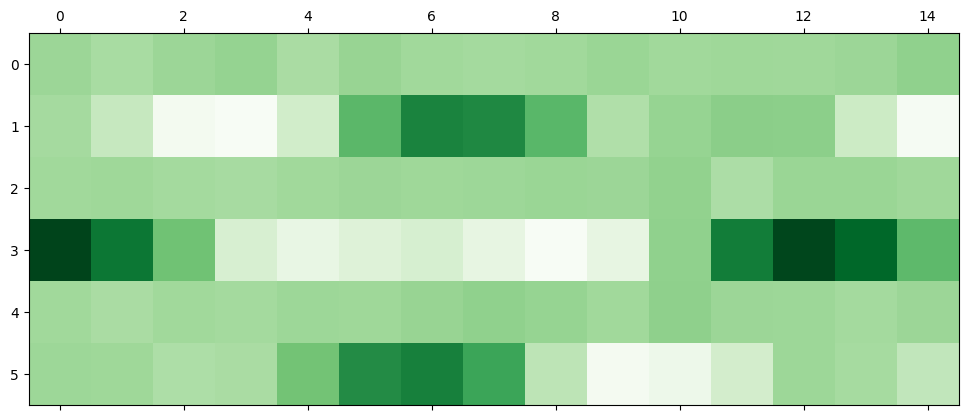

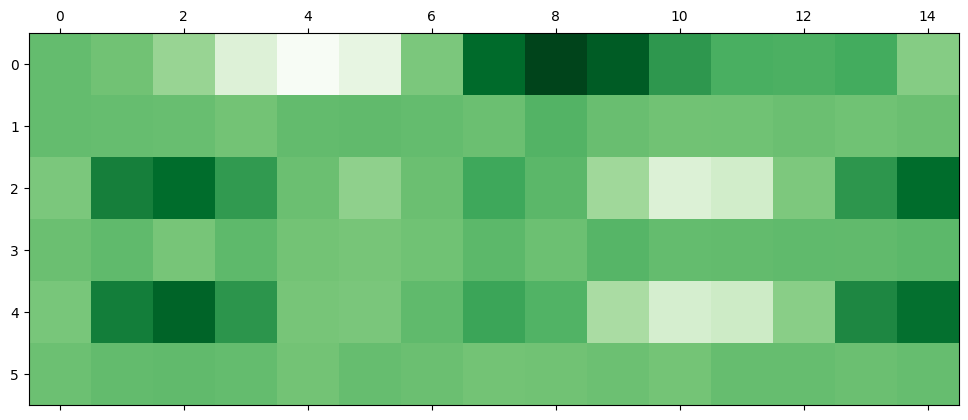

In [26]:
import matplotlib.pyplot as plt

evs_array_real = np.array(evs_array_real).T
evs_array_imag = np.array(evs_array_imag).T
plt.matshow(evs_array_real, cmap=plt.cm.Greens)
plt.matshow(evs_array_imag, cmap=plt.cm.Greens)

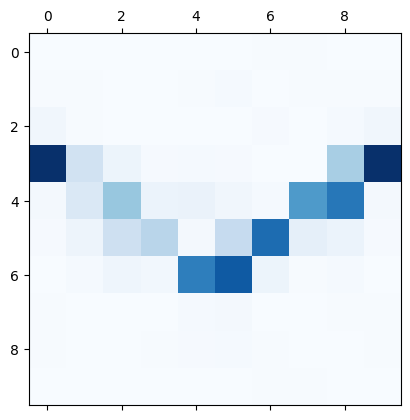

In [29]:
dft_array = dft_2d(evs_array)
dft_array = np.abs(dft_array)**2
plt.matshow(dft_array, cmap=plt.cm.Blues)


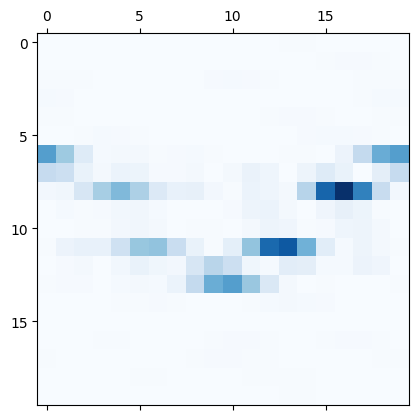

In [30]:
dft_array = dft_2d(evs_array,n_k = 20,n_w = 20)
dft_array = np.abs(dft_array)**2
plt.matshow(dft_array, cmap=plt.cm.Blues)